# Compression

In [1]:
import os
import matplotlib.pyplot as plt
import torch

In [2]:
torch.set_num_threads(1)
cwd = os.getcwd()

## Tensorize all models

In [10]:
embedding_fn = 'poly',
embed_dim = 2
# bond_dim = 5
domain_multiplier = 2
n_samples = 50

bond_dim_lst = ['Baseline', 2, 5, 10]
models_lst = ['Tiny', 'Small', 'Medium', 'Big', 'Large', 'Huge']

models_dir = os.path.join(cwd, '..', '..', 'results', '3_compression')

# Baseline accuracies
model_files = [
    list(filter(lambda f: f.startswith(f'fffc_{model.lower()}') and f.endswith('.pt'),
                os.listdir(models_dir)))[0]
    for model in models_lst]
model_accs = [float(file.split('_')[-1][:-3]) for file in model_files]


# Get max accuracies by bond_dim
max_accs_bond_dim_lst = [torch.tensor(model_accs)]
for bond_dim in bond_dim_lst[1:]:
    max_accs_lst = []
    for model in models_lst:
        cores_dir = cores_dir = os.path.join(
            models_dir,
            f'cores_fffc_{model.lower()}',
            f'{embed_dim}_{bond_dim}_{domain_multiplier}_{n_samples}')
        
        cores_lst = os.listdir(cores_dir)
        
        accs = []
        for file in cores_lst:
            accs.append(float(file.split('_')[1]))
        
        max_accs_lst.append(torch.tensor(accs).max())
    
    max_accs_bond_dim_lst.append(torch.stack(max_accs_lst, dim=0))

max_accs_bond_dim = torch.stack(max_accs_bond_dim_lst, dim=0)


# # Get distr of accuracies for bond_dim=5
# bond_dim = 5
# accs_quantiles_lst = []
# for model in models_lst:
#     cores_dir = cores_dir = os.path.join(
#         models_dir,
#         f'cores_fffc_{model.lower()}',
#         f'{embed_dim}_{bond_dim}_{domain_multiplier}_{n_samples}')
    
#     cores_lst = os.listdir(cores_dir)

#     quantiles = []
#     for file in cores_lst:
#         quantiles.append(float(file.split('_')[1]))
    
#     quantiles = torch.tensor(quantiles).quantile(q=torch.linspace(0., 1., 5))
#     accs_quantiles_lst.append(quantiles)

# accs_quantiles = torch.stack(accs_quantiles_lst, dim=1)


# Get all accuracies for bond_dim=5
bond_dim = 5
accs_quantiles_lst = []
for model in models_lst:
    cores_dir = cores_dir = os.path.join(
        models_dir,
        f'cores_fffc_{model.lower()}',
        f'{embed_dim}_{bond_dim}_{domain_multiplier}_{n_samples}')
    
    cores_lst = os.listdir(cores_dir)

    quantiles = []
    for file in cores_lst:
        quantiles.append(float(file.split('_')[1]))
    
    quantiles = torch.tensor(quantiles)
    accs_quantiles_lst.append(quantiles)

accs_quantiles = torch.stack(accs_quantiles_lst, dim=1)


# Get MI's by model
bond_dim = 2
mean_mean_mis_lst = []
mean_std_mis_lst = []
mean_max_mis_lst = []
for model in models_lst:
    cores_dir = os.path.join(
        models_dir,
        f'cores_fffc_{model.lower()}',
        f'{embed_dim}_{bond_dim}_{domain_multiplier}_{n_samples}')
    
    cores_lst = os.listdir(cores_dir)
    
    mean_mis = []
    std_mis = []
    max_mis = []
    for file in cores_lst:
        file_data = file.split('_')
        mean_mis.append(float(file_data[2]))
        std_mis.append(float(file_data[3]))
        max_mis.append(float(file_data[4][:-3]))
    
    mean_mean_mis_lst.append(torch.tensor(mean_mis).mean())
    mean_std_mis_lst.append(torch.tensor(std_mis).mean())
    mean_max_mis_lst.append(torch.tensor(max_mis).mean())
    
mean_mean_mis = torch.stack(mean_mean_mis_lst, dim=0)
mean_std_mis = torch.stack(mean_std_mis_lst, dim=0)
mean_max_mis = torch.stack(mean_max_mis_lst, dim=0)


# print(max_accs_bond_dim)
# print(accs_quantiles)
# print(mean_mean_mis, mean_std_mis, mean_max_mis)

### Figure

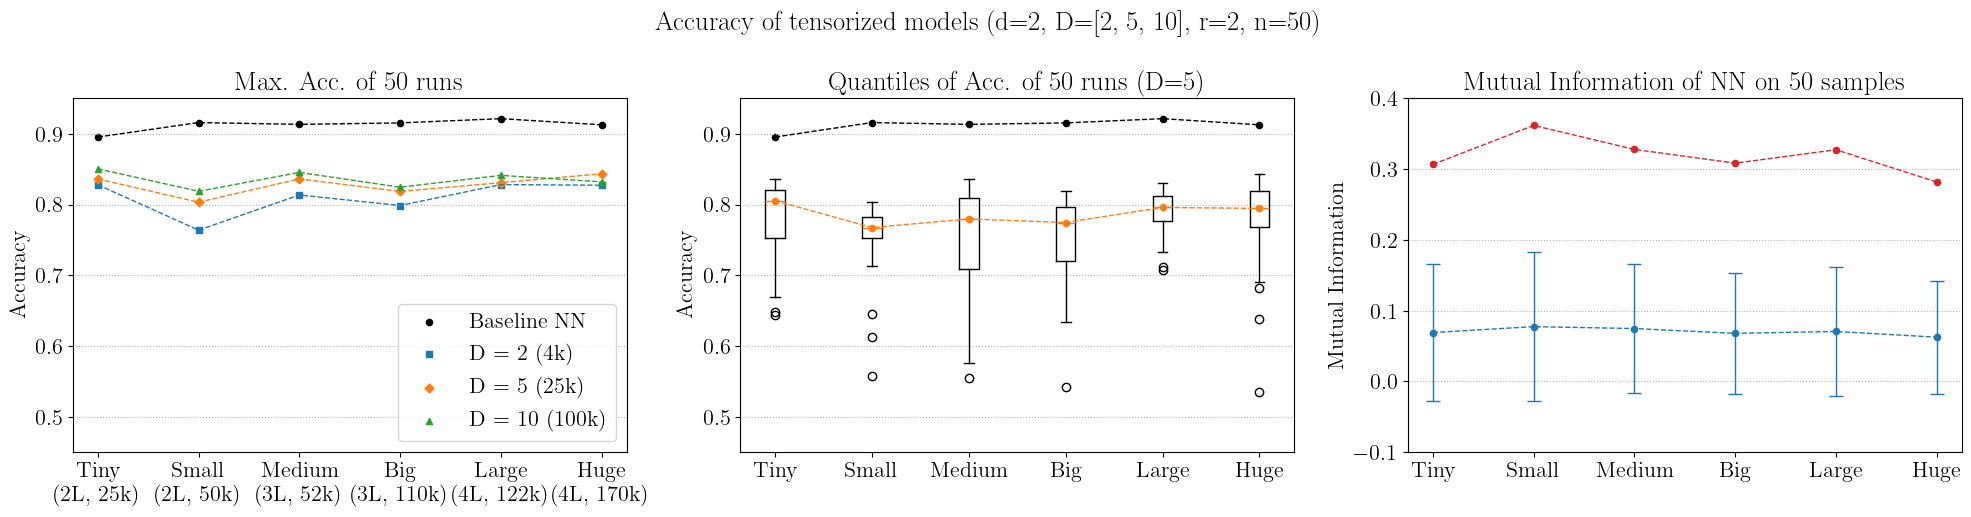

In [11]:
# plt.rc('font', family='serif', size=15)
plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)

colormap = plt.get_cmap("tab10")
colors = ['black', 'tab:blue', 'tab:orange', 'tab:green']

markers = ['o', 's', 'D', '^']
labels = ['Baseline NN', 'D = 2 (4k)', 'D = 5 (25k)', 'D = 10 (100k)']
model_sizes = {'Tiny': '(2L, 25k)',
               'Small':'(2L, 50k)',
               'Medium':'(3L, 52k)',
               'Big':'(3L, 110k)',
               'Large':'(4L, 122k)',
               'Huge': '(4L, 170k)'}

fig, axs = plt.subplots(1, 3, figsize=(20, 5.3))

# Accuracies tensorized models
# ----------------------------
for i, (D, accs) in enumerate(zip(bond_dim_lst, max_accs_bond_dim)):
    
    aux_models = [f'{m}\n{model_sizes[m]}' for m in models_lst]
        
    axs[0].plot(aux_models, accs, linestyle='--', linewidth=1., color=colors[i])
    axs[0].scatter(x=aux_models, y=accs, marker=markers[i], s=20.,
                   color=colors[i], label=labels[i])
    
# Set axes
axs[0].set_ylim(0.45, 0.95)
axs[0].yaxis.grid(linestyle=':')

# Adding labels and title
# axs[0].set_xlabel('Neural Network model')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right', bbox_to_anchor=(1., 0.))
axs[0].set_title('Max. Acc. of 50 runs')


# Quantiles of accuracies for bond_dim=5
# --------------------------------------
bp = axs[1].boxplot(x=accs_quantiles, positions=range(accs_quantiles.shape[1]),
                    widths=0.2, tick_labels=models_lst)

medians = []
for medline in bp['medians']:
    medians.append(medline.get_ydata()[0])

axs[1].plot(models_lst, medians, linestyle='--', linewidth=1.,
            color='tab:orange')
axs[1].scatter(x=models_lst, y=medians, marker='o', s=20.,
               color='tab:orange')


axs[1].plot(models_lst, max_accs_bond_dim[0], linestyle='--', linewidth=1.,
            color='black')
axs[1].scatter(x=models_lst, y=max_accs_bond_dim[0], marker='o', s=20.,
               color='black')

# line = accs_quantiles[2, :]
# errors1 = (accs_quantiles[[0, -1], :] - line.unsqueeze(0)).abs()
# errors2 = (accs_quantiles[[1, -2], :] - line.unsqueeze(0)).abs()

# axs[1].errorbar(x=models_lst, y=line, yerr=errors1, capsize=5.,
#                 linestyle='--', linewidth=1., color='tab:blue')
# axs[1].errorbar(x=models_lst, y=line, yerr=errors2, capsize=5.,
#                 linestyle='', linewidth=1., color='tab:blue')
# axs[1].scatter(x=models_lst, y=line, marker='o', s=20., color='tab:blue')

# Set axes
axs[1].set_ylim(0.45, 0.95)
axs[1].yaxis.grid(linestyle=':')

# Adding labels and title
# axs[1].set_xlabel('Neural Network model')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Quantiles of Acc. of 50 runs (D=5)')


# MIs NN models
# -------------
axs[2].errorbar(x=models_lst, y=mean_mean_mis, yerr=mean_std_mis, capsize=5.,
                linestyle='--', linewidth=1., color='tab:blue')
axs[2].scatter(x=models_lst, y=mean_mean_mis, marker='o', s=20., color='tab:blue')

axs[2].plot(models_lst, mean_max_mis, linestyle='--', linewidth=1., color='tab:red')
axs[2].scatter(x=models_lst, y=mean_max_mis, marker='o', s=20., color='tab:red')
    
# Set axes
axs[2].set_ylim(-0.1, 0.4)
axs[2].yaxis.grid(linestyle=':')

# Adding labels and title
# axs[2].set_xlabel('Neural Network model')
axs[2].set_ylabel('Mutual Information')
axs[2].set_title('Mutual Information of NN on 50 samples')


fig.suptitle('Accuracy of tensorized models (d=2, D=[2, 5, 10], r=2, n=50)')

plt.tight_layout(pad=1.)
plt.show()

## Best tensorized models retrained

In [5]:
embedding_fn = 'poly',
embed_dim = 2
# bond_dim = 5
domain_multiplier = 2
n_samples = 50

bond_dim_lst = ['Baseline', 2, 5, 10]
models_lst = ['Tiny', 'Small', 'Medium', 'Big', 'Large', 'Huge']

models_dir = os.path.join(cwd, '..', '..', 'results', '3_compression')

# Baseline accuracies
model_files = [
    list(filter(lambda f: f.startswith(f'fffc_{model.lower()}') and f.endswith('.pt'),
                os.listdir(models_dir)))[0]
    for model in models_lst]
model_accs = [float(file.split('_')[-1][:-3]) for file in model_files]


# Get max accuracies by bond_dim
max_accs_bond_dim_lst = [torch.tensor(model_accs)]
for bond_dim in bond_dim_lst[1:]:
    max_accs_lst = []
    for model in models_lst:
        cores_dir = os.path.join(
            models_dir,
            f'recores_fffc_{model.lower()}')
        cores_file = list(filter(lambda f: f.startswith(f'{bond_dim}'),
                                 os.listdir(cores_dir)))[0]
        
        max_accs_lst.append(torch.tensor(float(cores_file.split('_')[-1][:-3])))
    
    max_accs_bond_dim_lst.append(torch.stack(max_accs_lst, dim=0))

max_accs_bond_dim = torch.stack(max_accs_bond_dim_lst, dim=0)

### Figure

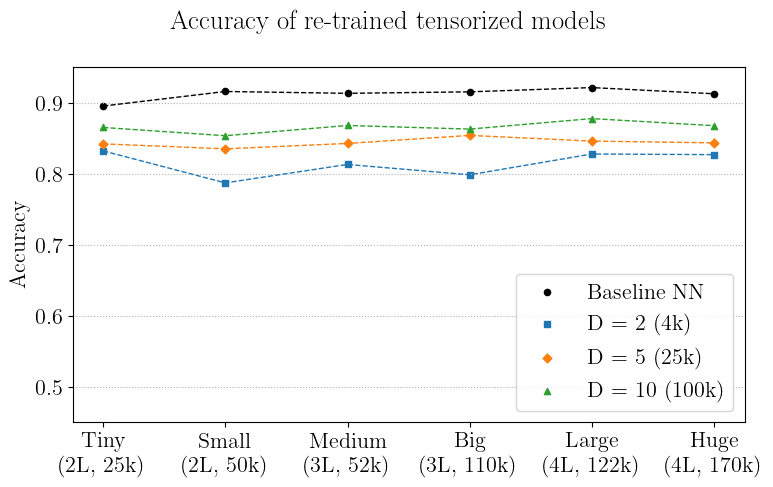

In [9]:
# plt.rc('font', family='serif', size=15)
plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)

colormap = plt.get_cmap("tab10")
colors = ['black', 'tab:blue', 'tab:orange', 'tab:green']

markers = ['o', 's', 'D', '^']
labels = ['Baseline NN', 'D = 2 (4k)', 'D = 5 (25k)', 'D = 10 (100k)']
model_sizes = {'Tiny': '(2L, 25k)',
               'Small':'(2L, 50k)',
               'Medium':'(3L, 52k)',
               'Big':'(3L, 110k)',
               'Large':'(4L, 122k)',
               'Huge': '(4L, 170k)'}

fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Accuracies tensorized models
# ----------------------------
for i, (D, accs) in enumerate(zip(bond_dim_lst, max_accs_bond_dim)):
    
    aux_models = [f'{m}\n{model_sizes[m]}' for m in models_lst]
        
    axs.plot(aux_models, accs, linestyle='--', linewidth=1., color=colors[i])
    axs.scatter(x=aux_models, y=accs, marker=markers[i], s=20.,
                color=colors[i], label=labels[i])
    
# Set axes
axs.set_ylim(0.45, 0.95)
axs.yaxis.grid(linestyle=':')

# Adding labels and title
# axs[0].set_xlabel('Neural Network model')
axs.set_ylabel('Accuracy')
axs.legend(loc='lower right', bbox_to_anchor=(1., 0.))
# axs[0].set_title('Max. Acc. of 50 runs')


fig.suptitle('Accuracy of re-trained tensorized models')

plt.tight_layout(pad=1.)
plt.show()

## Tensorize all models layer-wise

In [17]:
bond_dim_lst = ['Baseline', 2, 5, 10, 20]
models_lst = ['Tiny', 'Small', 'Medium', 'Big', 'Large', 'Huge']

models_dir = os.path.join(cwd, '..', '..', 'results', '3_compression')

# Baseline accuracies
model_files = [
    list(filter(lambda f: f.startswith(f'fffc_{model.lower()}') and f.endswith('.pt'),
                os.listdir(models_dir)))[0]
    for model in models_lst]
model_accs = [float(file.split('_')[-1][:-3]) for file in model_files]


sizes_bond_dim_lst = []
accs_bond_dim_lst = [torch.tensor(model_accs)]
for bond_dim in bond_dim_lst[1:]:
    sizes_models_lst = []
    accs_models_lst = []
    for model in models_lst:
        model_dir = os.path.join(models_dir,
                                f'fffc_{model.lower()}_tn')
        model_file = list(filter(lambda f: f.startswith(f'{bond_dim}_'),
                                 os.listdir(model_dir)))[0].split('_')
        
        model_size = int(model_file[2])
        model_acc = float(model_file[3])
    
        sizes_models_lst.append(model_size)
        accs_models_lst.append(model_acc)
    
    sizes_bond_dim_lst.append(torch.tensor(sizes_models_lst))
    accs_bond_dim_lst.append(torch.tensor(accs_models_lst))
    
sizes_bond_dim = torch.stack(sizes_bond_dim_lst, dim=0)
accs_bond_dim = torch.stack(accs_bond_dim_lst, dim=0)

sizes_bond_dim, accs_bond_dim

(tensor([[  384,   450,   618,   836,  1070,  1368],
         [ 1221,  1575,  2163,  2888,  3764,  4758],
         [ 3446,  4200,  5238,  7112,  8838, 12080],
         [11646, 12900, 15138, 18512, 21938, 30960]]),
 tensor([[0.8954, 0.9159, 0.9133, 0.9154, 0.9214, 0.9127],
         [0.7281, 0.5475, 0.7972, 0.7061, 0.6320, 0.7111],
         [0.7306, 0.8176, 0.8213, 0.7768, 0.8132, 0.7890],
         [0.8680, 0.8715, 0.8694, 0.8525, 0.8535, 0.8356],
         [0.8934, 0.9041, 0.8967, 0.8765, 0.8731, 0.8860]]))

### Figure

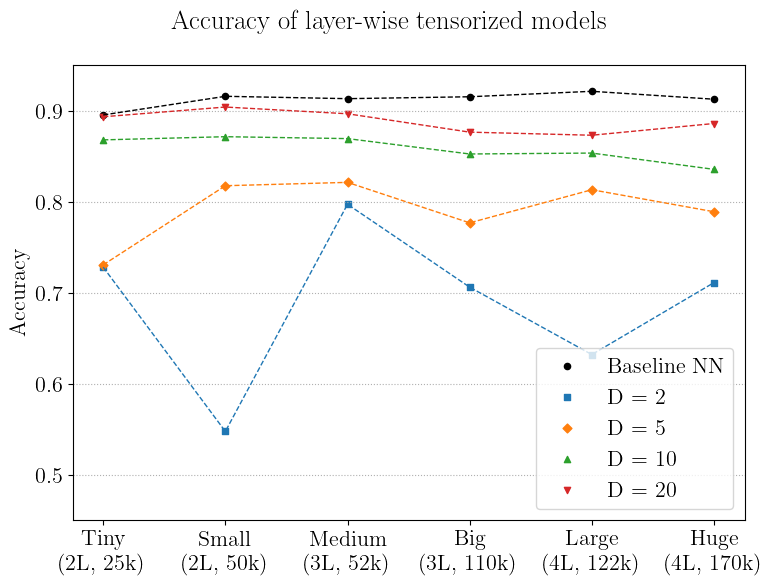

In [18]:
# plt.rc('font', family='serif', size=15)
plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)

colormap = plt.get_cmap("tab10")
colors = ['black', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']

markers = ['o', 's', 'D', '^', 'v']
labels = ['Baseline NN', 'D = 2', 'D = 5', 'D = 10', 'D = 20']
model_sizes = {'Tiny': '(2L, 25k)',
               'Small':'(2L, 50k)',
               'Medium':'(3L, 52k)',
               'Big':'(3L, 110k)',
               'Large':'(4L, 122k)',
               'Huge': '(4L, 170k)'}

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

# Accuracies tensorized models
# ----------------------------
for i, (D, accs) in enumerate(zip(bond_dim_lst, accs_bond_dim)):
    
    aux_models = [f'{m}\n{model_sizes[m]}' for m in models_lst]
        
    axs.plot(aux_models, accs, linestyle='--', linewidth=1., color=colors[i])
    axs.scatter(x=aux_models, y=accs, marker=markers[i], s=20.,
                   color=colors[i], label=labels[i])
    
# Set axes
axs.set_ylim(0.45, 0.95)
axs.yaxis.grid(linestyle=':')

# Adding labels and title
# axs[0].set_xlabel('Neural Network model')
axs.set_ylabel('Accuracy')
axs.legend(loc='lower right', bbox_to_anchor=(1., 0.))


fig.suptitle('Accuracy of layer-wise tensorized models')

plt.tight_layout(pad=1.)
plt.show()

## Best tensorized models layer-wise retrained

In [20]:
bond_dim_lst = ['Baseline', 2, 5, 10, 20]
models_lst = ['Tiny', 'Small', 'Medium', 'Big', 'Large', 'Huge']

models_dir = os.path.join(cwd, '..', '..', 'results', '3_compression')

# Baseline accuracies
model_files = [
    list(filter(lambda f: f.startswith(f'fffc_{model.lower()}') and f.endswith('.pt'),
                os.listdir(models_dir)))[0]
    for model in models_lst]
model_accs = [float(file.split('_')[-1][:-3]) for file in model_files]


sizes_bond_dim_lst = []
accs_bond_dim_lst = [torch.tensor(model_accs)]
for bond_dim in bond_dim_lst[1:]:
    sizes_models_lst = []
    accs_models_lst = []
    for model in models_lst:
        model_dir = os.path.join(models_dir,
                                f'fffc_{model.lower()}_tn')
        model_file = list(filter(lambda f: f.startswith(f'{bond_dim}_'),
                                 os.listdir(model_dir)))[0].split('_')
        
        model_size = int(model_file[2])
        model_acc = float(model_file[4][:-3])
    
        sizes_models_lst.append(model_size)
        accs_models_lst.append(model_acc)
    
    sizes_bond_dim_lst.append(torch.tensor(sizes_models_lst))
    accs_bond_dim_lst.append(torch.tensor(accs_models_lst))
    
sizes_bond_dim = torch.stack(sizes_bond_dim_lst, dim=0)
accs_bond_dim = torch.stack(accs_bond_dim_lst, dim=0)

sizes_bond_dim, accs_bond_dim

(tensor([[  384,   450,   618,   836,  1070,  1368],
         [ 1221,  1575,  2163,  2888,  3764,  4758],
         [ 3446,  4200,  5238,  7112,  8838, 12080],
         [11646, 12900, 15138, 18512, 21938, 30960]]),
 tensor([[0.8954, 0.9159, 0.9133, 0.9154, 0.9214, 0.9127],
         [0.8322, 0.8087, 0.8273, 0.8326, 0.8335, 0.8396],
         [0.8803, 0.8647, 0.8828, 0.8715, 0.8637, 0.8536],
         [0.8736, 0.8931, 0.8914, 0.8827, 0.8772, 0.8857],
         [0.8786, 0.8982, 0.9050, 0.9006, 0.8933, 0.8992]]))

### Figure

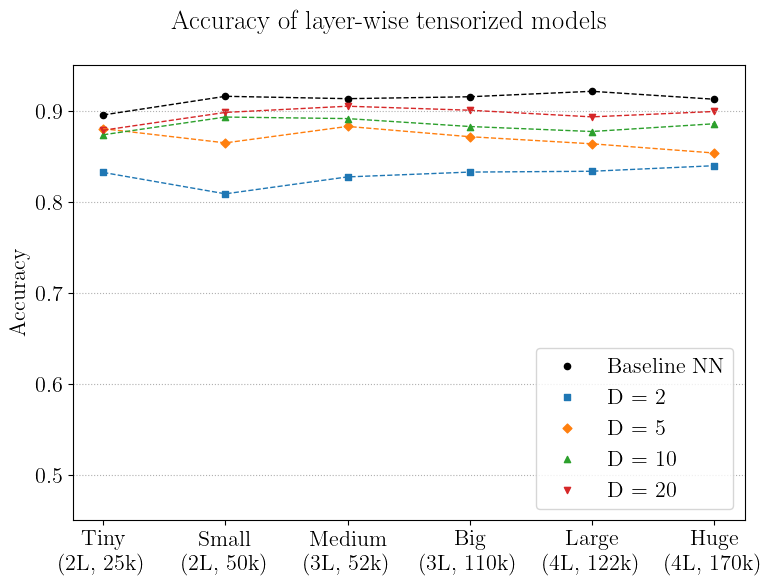

In [21]:
# plt.rc('font', family='serif', size=15)
plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)

colormap = plt.get_cmap("tab10")
colors = ['black', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']

markers = ['o', 's', 'D', '^', 'v']
labels = ['Baseline NN', 'D = 2', 'D = 5', 'D = 10', 'D = 20']
model_sizes = {'Tiny': '(2L, 25k)',
               'Small':'(2L, 50k)',
               'Medium':'(3L, 52k)',
               'Big':'(3L, 110k)',
               'Large':'(4L, 122k)',
               'Huge': '(4L, 170k)'}

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

# Accuracies tensorized models
# ----------------------------
for i, (D, accs) in enumerate(zip(bond_dim_lst, accs_bond_dim)):
    
    aux_models = [f'{m}\n{model_sizes[m]}' for m in models_lst]
        
    axs.plot(aux_models, accs, linestyle='--', linewidth=1., color=colors[i])
    axs.scatter(x=aux_models, y=accs, marker=markers[i], s=20.,
                   color=colors[i], label=labels[i])
    
# Set axes
axs.set_ylim(0.45, 0.95)
axs.yaxis.grid(linestyle=':')

# Adding labels and title
# axs[0].set_xlabel('Neural Network model')
axs.set_ylabel('Accuracy')
axs.legend(loc='lower right', bbox_to_anchor=(1., 0.))


fig.suptitle('Accuracy of layer-wise tensorized models')

plt.tight_layout(pad=1.)
plt.show()